In [1]:
#!/usr/bin/env python3
"""logistic_regression
James Gardner 2019

performs logistic regression on feature vectors
against positional matching labels
using pytorch
"""

import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

import torch
from torch.autograd import Variable
import torch.nn.functional as F

In [2]:
# Step 1. Load Dataset
# Step 2. Make Dataset Iterable
# Step 3. Create Model Class
# Step 4. Instantiate Model Class
# Step 5. Instantiate Loss Class
# Step 6. Instantiate Optimizer Class
# Step 7. Train Model

In [3]:
catalogue = pd.read_csv('patch_catalogue.csv')
catalogue.set_index(['name_TGSS','name_NVSS'],inplace=True)

scores = catalogue['score']
del (catalogue['ra_TGSS'],catalogue['dec_TGSS'],
     catalogue['ra_NVSS'],catalogue['dec_NVSS'],
     catalogue['score'])

catalogue['log_flux_TGSS']       = np.log10(catalogue['peak_TGSS'])
catalogue['log_integrated_TGSS'] = np.log10(catalogue['integrated_TGSS'])
catalogue['log_ratio_flux_TGSS'] = np.log10(catalogue['peak_TGSS']/
                                            catalogue['integrated_TGSS'])
catalogue['log_flux_NVSS']       = np.log10(catalogue['peak_NVSS'])

In [4]:
labels = (scores.values > 0.1)
features = catalogue.values

labels = Variable(torch.from_numpy(labels).float())
features = Variable(torch.Tensor(features))

In [5]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = torch.nn.Linear(input_dim, 1)
        
    def forward(self, x):
        outputs = F.sigmoid(self.linear(x))
        return outputs

In [24]:
# some of the hyper-parameters
input_dim = features.shape[1]
# time-step
learning_rate = 0.001

# batch_size = 100
# n_iters    = 3000
# num_epochs = n_iters / (len(x_data) / batch_size)
num_epochs = 1000

In [25]:
model = LogisticRegression(input_dim)
# criterion = torch.nn.CrossEntropyLoss()
criterion = torch.nn.BCELoss(size_average=True)
# unbiased estimate (noisy observation)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

/home/james/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [26]:
losses = []
for epoch in tqdm(range(num_epochs)):
    # reset gradient accumulation
    optimizer.zero_grad()
    # forward step
    predictions = model(features)
    loss = criterion(predictions, labels)
    # use item to stop memory leak to GPU
    losses.append(loss.item())
    # backwards step
    loss.backward()
    optimizer.step()

/home/james/.local/lib/python3.6/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/james/.local/lib/python3.6/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([30664])) that is different to the input size (torch.Size([30664, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


In [34]:
predictions = model(features).detach().numpy()
pred_labels = (predictions > 0.5).astype(float)
accuracy = (pred_labels == labels.numpy()).mean()

/home/james/.local/lib/python3.6/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [37]:
print(accuracy)

0.6330481290561071


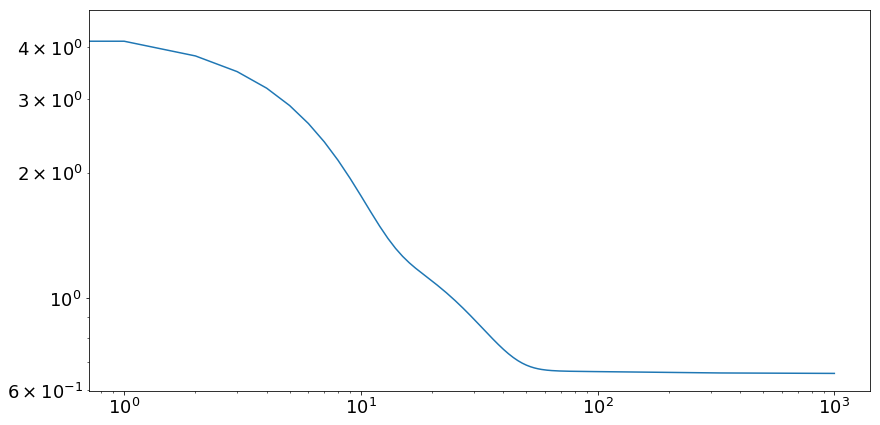

In [38]:
plt.figure(figsize=(14,7))
plt.rcParams.update({'font.size': 18})
plt.plot(losses)
plt.xscale('log')
plt.yscale('log')

In [39]:
weights = list(model.parameters())
weights = weights[0].detach().numpy().ravel()

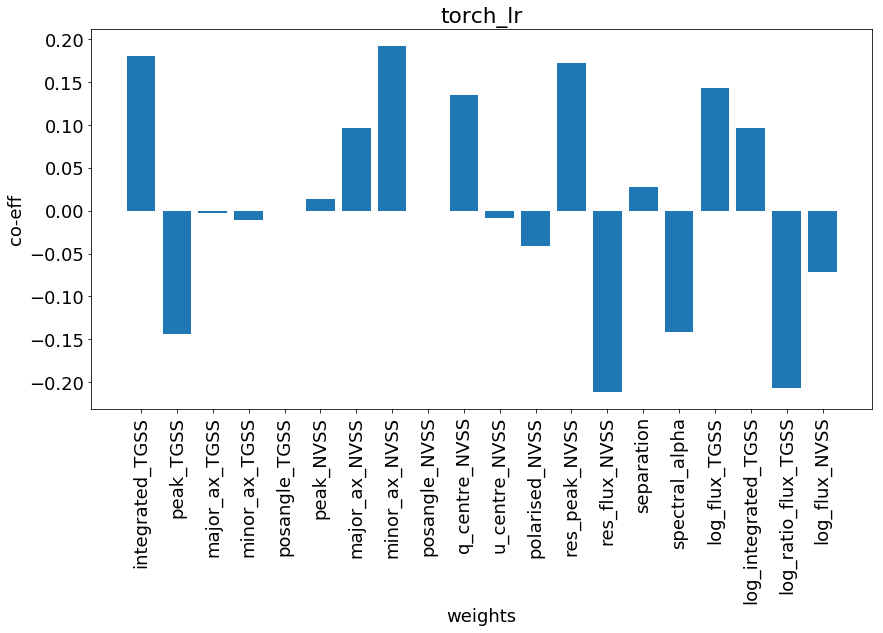

In [40]:
plt.figure(figsize=(14,7))
plt.rcParams.update({'font.size': 18})
plt.bar(range(len(weights)),weights)
plt.xlabel('weights')
plt.xticks(range(len(weights)),catalogue.columns,rotation='vertical')
plt.ylabel('co-eff')
plt.title('torch_lr')
plt.savefig('torch_lr.pdf',bbox_inches='tight') 
# plt.close()

In [ ]:
# model = LinearRegression()
# criterion = torch.nn.MSELoss(size_average=False)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)